# 1. Import Libraries

In [1]:
import tensorflow as tf
gpu = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpu[0], True)

In [2]:
import re
import math
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter
from keras.utils import to_categorical
from imblearn.under_sampling import RandomUnderSampler
from tqdm.notebook import tqdm
tqdm.pandas()

from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPooling1D, LSTM, GRU, Embedding,\
    BatchNormalization, LeakyReLU, Dropout, ReLU, Bidirectional 

from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import  MinMaxScaler, PowerTransformer, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, \
mean_squared_error, r2_score, mean_absolute_error, classification_report 

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression, PassiveAggressiveClassifier
from sklearn.ensemble import (
    GradientBoostingClassifier, 
    AdaBoostClassifier, 
    RandomForestClassifier,
    BaggingClassifier,
    ExtraTreesClassifier,
    RandomForestClassifier,
    StackingClassifier,
    HistGradientBoostingClassifier
)
from xgboost import XGBClassifier

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download("vader_lexicon")

from faker import Faker


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\indiz\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\indiz\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\indiz\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\indiz\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# 2. Load Data

In [118]:
categories = ['talk.religion.misc', 'soc.religion.christian', 'sci.space', 'comp.graphics']

data_list = fetch_20newsgroups(subset='all',categories=categories)

data = pd.DataFrame()
data['data'] = pd.DataFrame(data_list.data)
data['class'] = pd.DataFrame(data_list.target)
data

,data,class
0,Subject: Re: [rw] Is Robert Weiss the only ort...,3
1,From: aidler@sol.uvic.ca (E Alan Idler)\nSubj...,2
2,From: susan_soric@upubs.uchicago.edu (Susan So...,3
3,From: jtk@s1.gov (Jordin Kare)\nSubject: Re: I...,1
4,From: hollasch@kpc.com (Steve Hollasch)\nSubje...,0
...,...,...
3580,From: Christopher.S.Weinberger@williams.edu (G...,2
3581,From: ch981@cleveland.Freenet.Edu (Tony Alicea...,3
3582,From: mccall@mksol.dseg.ti.com (fred j mccall ...,1
3583,From: bkidd@esk.compserv.utas.edu.au ( Byron J...,0


# 3. Initial Analysis

### 3.1. Metadata

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29692 entries, 0 to 64230
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   App                     29692 non-null  object 
 1   Translated_Review       29692 non-null  object 
 2   Sentiment               29692 non-null  object 
 3   Sentiment_Polarity      29692 non-null  float64
 4   Sentiment_Subjectivity  29692 non-null  float64
dtypes: float64(2), object(3)
memory usage: 1.4+ MB


In [9]:
data.isnull().sum()

App                       0
Translated_Review         0
Sentiment                 0
Sentiment_Polarity        0
Sentiment_Subjectivity    0
dtype: int64

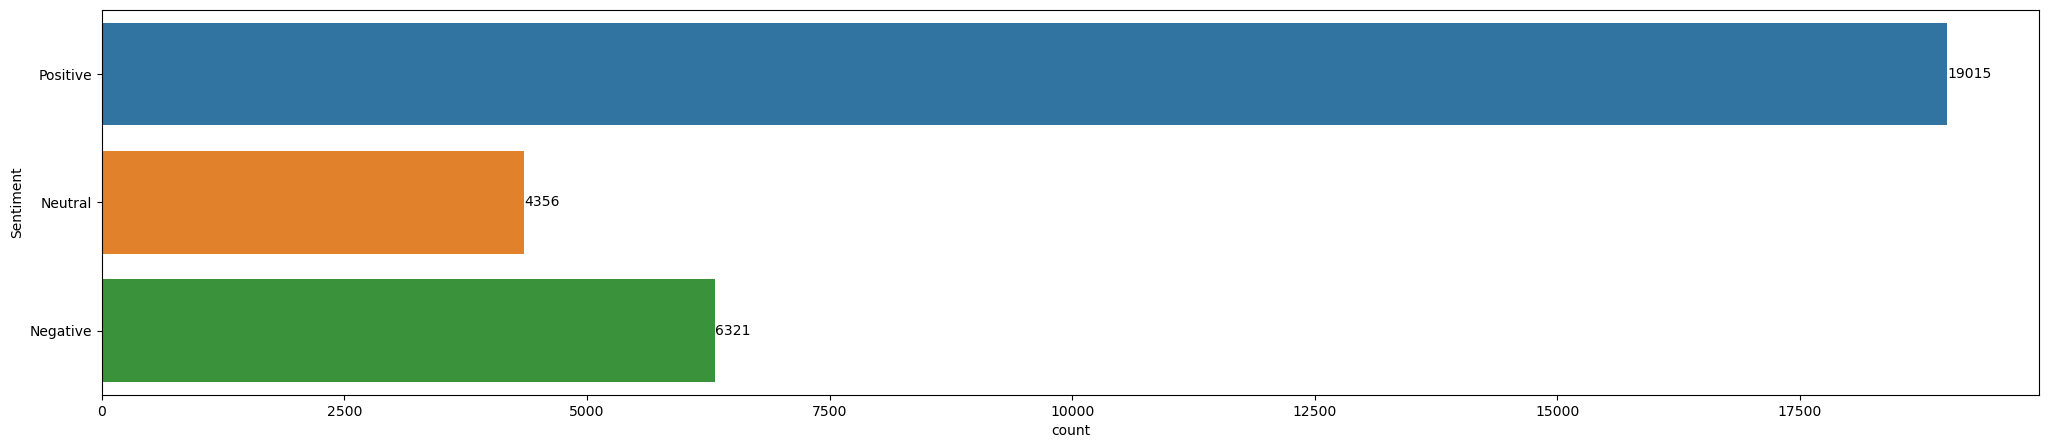

In [10]:
plt.subplots(figsize = (25,5))
ax = sns.countplot(data, y = data['Sentiment'])
ax.bar_label(ax.containers[0])
plt.show()

### 3.2. Processing Columns

In [119]:
def extract_lines(text):
    words = text.split()
    try:
        index = words.index("Lines:")
        lines = " ".join(words[index+2:])
        return lines
    except ValueError:
        return ""

data['text'] = data['data'].apply(extract_lines)
data

,data,class,text
0,Subject: Re: [rw] Is Robert Weiss the only ort...,3,"In article <C5vGyD.H7s@acsu.buffalo.edu>, psyr..."
1,From: aidler@sol.uvic.ca (E Alan Idler)\nSubj...,2,"muddmj@wkuvx1.bitnet writes: >> But, haven't ""..."
2,From: susan_soric@upubs.uchicago.edu (Susan So...,3,I'm greatly in need of Jurgen Moltmann's book ...
3,From: jtk@s1.gov (Jordin Kare)\nSubject: Re: I...,1,Distribution: world NNTP-Posting-Host: s1.gov ...
4,From: hollasch@kpc.com (Steve Hollasch)\nSubje...,0,"lioness@maple.circa.ufl.edu: > Okay, I got eno..."
...,...,...,...
3580,From: Christopher.S.Weinberger@williams.edu (G...,2,In article <Apr.19.05.13.28.1993.29224@athos.r...
3581,From: ch981@cleveland.Freenet.Edu (Tony Alicea...,3,Reply-To: ch981@cleveland.Freenet.Edu (Tony Al...
3582,From: mccall@mksol.dseg.ti.com (fred j mccall ...,1,In <1993Apr5.195215.16833@pixel.kodak.com> dj@...
3583,From: bkidd@esk.compserv.utas.edu.au ( Byron J...,0,"Sorry if this is a FAQ but : ""Where can I get ..."


In [120]:
stopword_en = pd.read_csv('../en_stopword_1106.txt', header=None).drop_duplicates()
en_stopword = stopword_en[0].values.tolist()
en_stopword = [word.strip() for word in en_stopword]

nltk_stopword = stopwords.words('english')

combined_stopwords = pd.DataFrame(en_stopword + nltk_stopword).drop_duplicates()
stopword_list = combined_stopwords[0].values.tolist()

def lower_text(text):
    return text.lower()

def alphanumeric_text(text):
    # return re.sub("[^a-z0-9\s]","", text)
    text = text.lower()
    return re.sub(r'[^\w\s.,]', '', text)

def remove_duplicate_words(text):
    return re.sub(r'\b(\w+)(\s+\1)+\b', r'\1', text)

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'@[a-z0-9_]+', '', text) # Removes Twitter usernames
    text = re.sub('rt|cc', ' ', text)  # remove RT and cc
    text = re.sub('#', '', text)  # remove hashtags
    text = re.sub('@\S+', '  ', text)  # remove mentions
    text = re.sub('\[.*?\]', '', text) # Removes all text enclosed in square brackets 
    text = re.sub('<.*?>+', '', text) # remove html tags
    text = re.sub('https?://\S+|www\.\S+', '', text) # remove URLs
    text = re.sub('\s+', ' ', text)  # remove extra whitespace
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text) # remove punctuations
    text = re.sub(r'[^\w\s.,]', '', text) # Removes all non-word characters
    # text = [word for word in text.split(' ') if word not in nltk_stopword]
    return text


def stop_word(text):
    return " ".join([word for word in text.split(' ') if word not in nltk_stopword])

lemmatizer = WordNetLemmatizer()

def lemmatize_word(word):
    return lemmatizer.lemmatize(word, pos='v')

def lemmatize_sentence(sentence):
    words = nltk.word_tokenize(sentence) 
    words = [word for word in words if word.isalnum()] 
    words = [lemmatize_word(word) for word in words]  
    return ' '.join(words)  

In [121]:
data['clean_text'] = data['text'] \
                    .progress_apply(clean_text) \
                    .progress_apply(stop_word) \
                    .progress_apply(lemmatize_sentence)
data

  0%|          | 0/3585 [00:00<?, ?it/s]

  0%|          | 0/3585 [00:00<?, ?it/s]

  0%|          | 0/3585 [00:00<?, ?it/s]

,data,class,text,clean_text
0,Subject: Re: [rw] Is Robert Weiss the only ort...,3,"In article <C5vGyD.H7s@acsu.buffalo.edu>, psyr...",icle psyrobtw buffaloedu robe weiss say hodox ...
1,From: aidler@sol.uvic.ca (E Alan Idler)\nSubj...,2,"muddmj@wkuvx1.bitnet writes: >> But, haven't ""...",muddmjbitnet write havent sin come sho glory g...
2,From: susan_soric@upubs.uchicago.edu (Susan So...,3,I'm greatly in need of Jurgen Moltmann's book ...,im greatly need jurgen moltmanns book god crea...
3,From: jtk@s1.gov (Jordin Kare)\nSubject: Re: I...,1,Distribution: world NNTP-Posting-Host: s1.gov ...,distribution world nntppostinghost s1gov yamau...
4,From: hollasch@kpc.com (Steve Hollasch)\nSubje...,0,"lioness@maple.circa.ufl.edu: > Okay, I got eno...",lionesscircaufledu okay get enough reply kubot...
...,...,...,...,...
3580,From: Christopher.S.Weinberger@williams.edu (G...,2,In article <Apr.19.05.13.28.1993.29224@athos.r...,icle rolfedsuedu tim rolfe write romans 828 rs...
3581,From: ch981@cleveland.Freenet.Edu (Tony Alicea...,3,Reply-To: ch981@cleveland.Freenet.Edu (Tony Al...,replyto ch981freenetedu tony alicea nntppostin...
3582,From: mccall@mksol.dseg.ti.com (fred j mccall ...,1,In <1993Apr5.195215.16833@pixel.kodak.com> dj@...,djssdkodakcom dave jones write keith mancus ma...
3583,From: bkidd@esk.compserv.utas.edu.au ( Byron J...,0,"Sorry if this is a FAQ but : ""Where can I get ...",sorry faq get 286 16 bite version povray help ...


### 3.3. Add label for Sentiment Analysis using Vader NLTK

In [16]:
sentiments = SentimentIntensityAnalyzer()
data["Positive"] = [sentiments.polarity_scores(i)["pos"] for i in data["clean_text"]]
data["Negative"] = [sentiments.polarity_scores(i)["neg"] for i in data["clean_text"]]
data["Neutral"]  = [sentiments.polarity_scores(i)["neu"] for i in data["clean_text"]]
data['Compound'] = [sentiments.polarity_scores(i)["compound"] for i in data["clean_text"]]
data

,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity,clean_text,Positive,Negative,Neutral,Compound
0,I like eat delicious food. That's I'm cooking ...,Positive,1.000000,0.533333,like eat delicious food thats im cook food cas...,0.571,0.000,0.429,0.9538
1,This help eating healthy exercise regular basis,Positive,0.250000,0.288462,help eat healthy exercise regular basis,0.574,0.000,0.426,0.6597
2,Works great especially going grocery store,Positive,0.400000,0.875000,work great especially go grocery store,0.451,0.000,0.549,0.6249
3,Best idea us,Positive,1.000000,0.300000,best idea us,0.677,0.000,0.323,0.6369
4,Best way,Positive,1.000000,0.300000,best way,0.808,0.000,0.192,0.6369
...,...,...,...,...,...,...,...,...,...
29687,Most ads older many agents ..not much owner po...,Positive,0.173333,0.486667,ads older many agents much owner post detail r...,0.000,0.171,0.829,-0.4767
29688,"If photos posted portal load, fit purpose. I'm...",Positive,0.225000,0.447222,photos post po al load fit purpose im sure sto...,0.216,0.140,0.644,0.4019
29689,"Dumb app, I wanted post property rent give opt...",Negative,-0.287500,0.250000,dumb app want post prope rent give option webs...,0.071,0.332,0.598,-0.7003
29690,I property business got link SMS happy perform...,Positive,0.800000,1.000000,prope business get link sms happy performance ...,0.368,0.000,0.632,0.7906


In [17]:
score = data["Compound"].values
sentiment = []
for i in score:
    if i >= 0.1 :
        sentiment.append('Positive')
    elif i < -0.1 :
        sentiment.append('Negative')
    else:
        sentiment.append('Neutral')
data["Sentiment_Vader"] = pd.DataFrame(sentiment)
data

,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity,clean_text,Positive,Negative,Neutral,Compound,Sentiment_Vader
0,I like eat delicious food. That's I'm cooking ...,Positive,1.000000,0.533333,like eat delicious food thats im cook food cas...,0.571,0.000,0.429,0.9538,Positive
1,This help eating healthy exercise regular basis,Positive,0.250000,0.288462,help eat healthy exercise regular basis,0.574,0.000,0.426,0.6597,Positive
2,Works great especially going grocery store,Positive,0.400000,0.875000,work great especially go grocery store,0.451,0.000,0.549,0.6249,Positive
3,Best idea us,Positive,1.000000,0.300000,best idea us,0.677,0.000,0.323,0.6369,Positive
4,Best way,Positive,1.000000,0.300000,best way,0.808,0.000,0.192,0.6369,Positive
...,...,...,...,...,...,...,...,...,...,...
29687,Most ads older many agents ..not much owner po...,Positive,0.173333,0.486667,ads older many agents much owner post detail r...,0.000,0.171,0.829,-0.4767,Negative
29688,"If photos posted portal load, fit purpose. I'm...",Positive,0.225000,0.447222,photos post po al load fit purpose im sure sto...,0.216,0.140,0.644,0.4019,Positive
29689,"Dumb app, I wanted post property rent give opt...",Negative,-0.287500,0.250000,dumb app want post prope rent give option webs...,0.071,0.332,0.598,-0.7003,Negative
29690,I property business got link SMS happy perform...,Positive,0.800000,1.000000,prope business get link sms happy performance ...,0.368,0.000,0.632,0.7906,Positive


In [26]:
data["Sentiment"].value_counts()

Positive    19015
Negative     6321
Neutral      4356
Name: Sentiment, dtype: int64

In [27]:
data["Sentiment_Vader"].value_counts()

Positive    19808
Negative     5472
Neutral      4412
Name: Sentiment_Vader, dtype: int64

In [32]:
data['Compare'] = data["Sentiment"] == data["Sentiment_Vader"]
data['Compare'].value_counts()

True     22290
False     7402
Name: Compare, dtype: int64

### 3.4. Count Sentence in a Record

1
5584


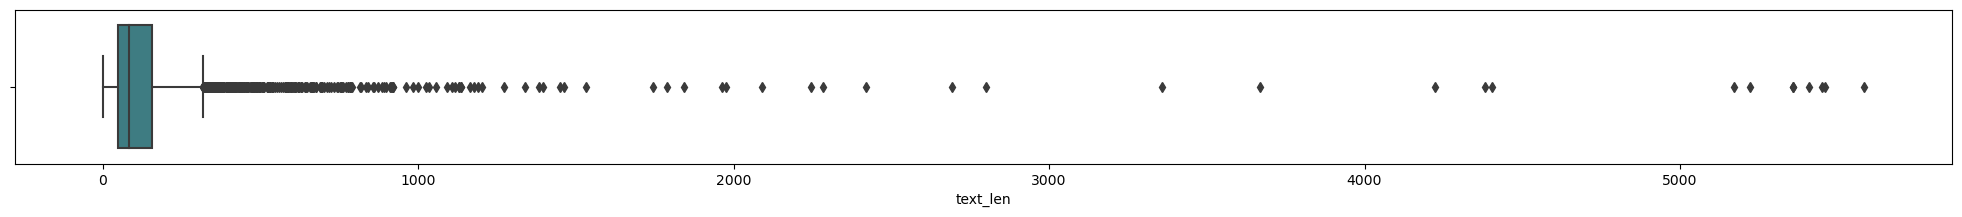

In [122]:
text_len = [len(word) for word in data['clean_text'].str.split(' ')]
data['text_len'] = pd.DataFrame(text_len)
print(data['text_len'].min())
print(data['text_len'].max())


fig, ax = plt.subplots(figsize=(25, 2))
sns.boxplot(x=data['text_len'], palette="crest")
plt.show()

In [123]:
print(data['text_len'].quantile(.01))
print(data['text_len'].quantile(.75))

7.0
156.0


In [95]:
len(data[data['text_len'] < 150])

8654

### 3.5. Remove outliers based-on length of the sentences

<Axes: xlabel='text_len'>

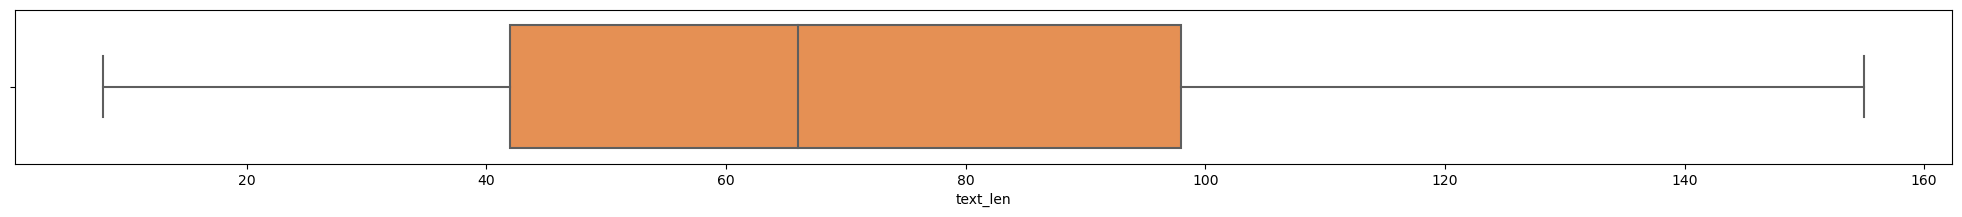

In [124]:
Q1 = data['text_len'].quantile(.01)
Q3 = data['text_len'].quantile(.75)

data = data[(data['text_len'] > Q1) & (data['text_len'] < Q3)]

fig, axes = plt.subplots(figsize=(25, 2))
sns.boxplot(x = data['text_len'], palette="Oranges")

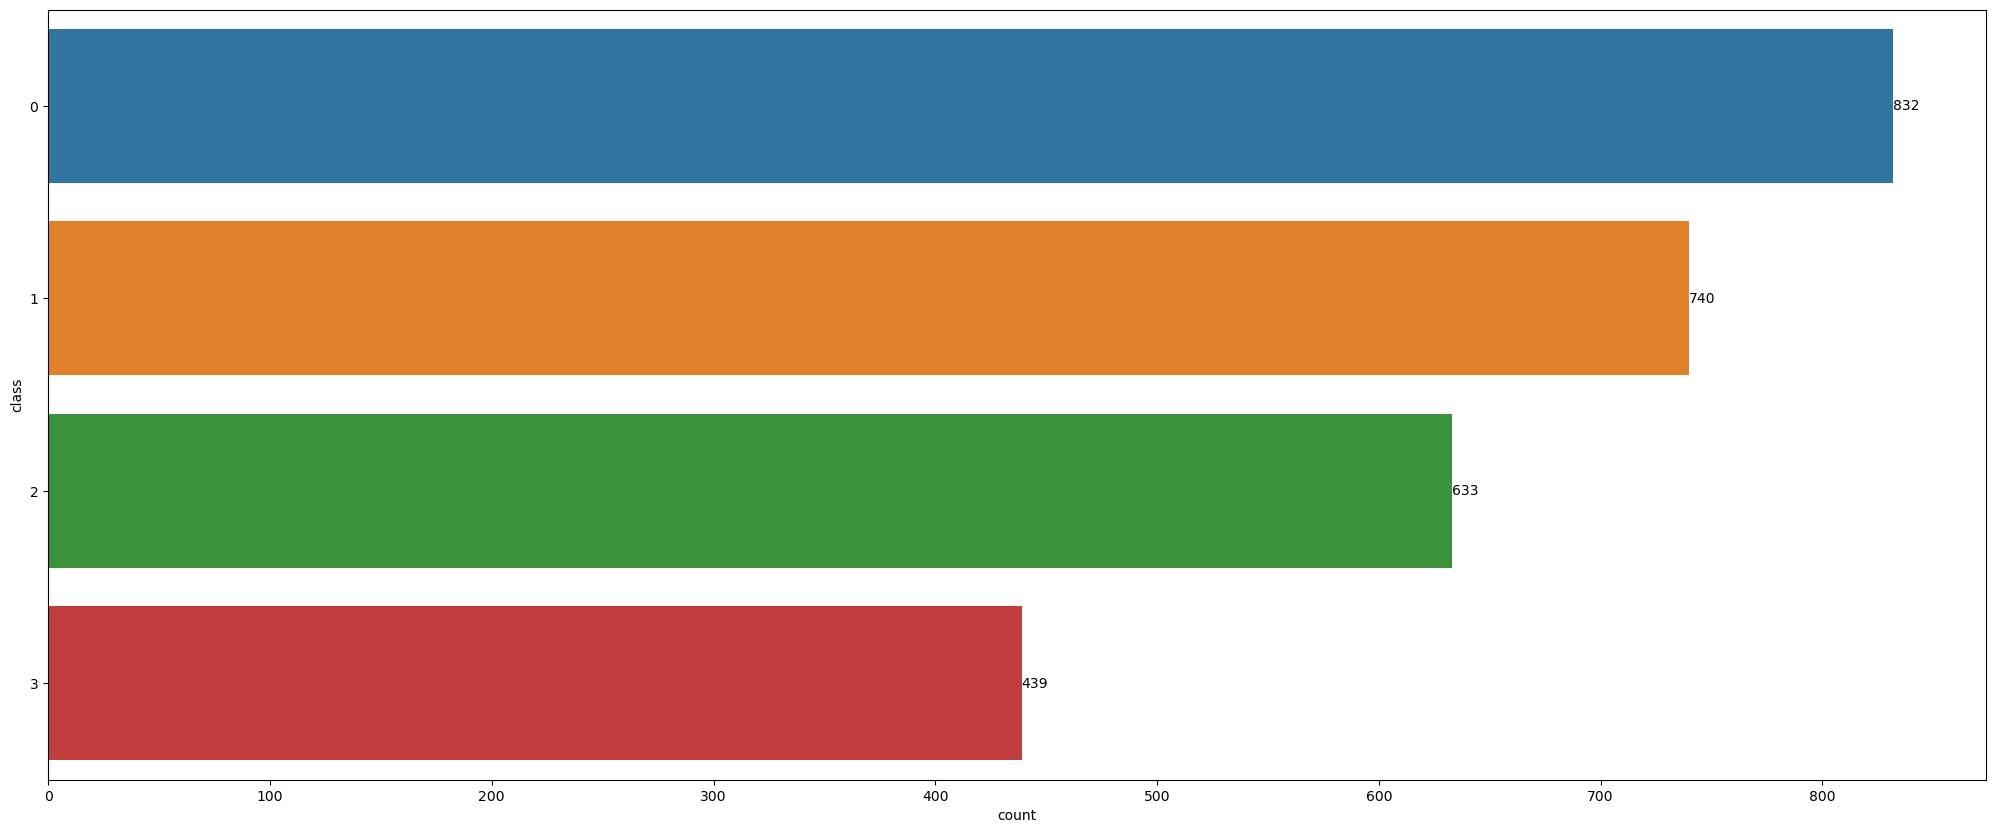

In [125]:
plt.subplots(figsize = (25,10))
ax = sns.countplot(data, y = data['class'])
ax.bar_label(ax.containers[0])
plt.show()

# 4. Preparing Dataset

In [142]:
LE = LabelEncoder()

X = data['clean_text']
# Y = LE.fit_transform(data['label']) ### For Classification Algoritms
Y = pd.get_dummies(data['class']) ### For Deep Learning Algoritms
# Y = data['class'] ### For Deep Learning Algoritms

X_train, X_val, y_train, y_val = train_test_split(X, Y, train_size=0.9, random_state = 42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, train_size=0.78, random_state = 42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_val.shape, y_val.shape)

(1855,) (1855, 4)
(524,) (524, 4)
(265,) (265, 4)


In [143]:
vocab_size = 20_000
embedding_dim = 128
max_length = 157
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"
num_label = y_train.shape[1]

In [ ]:
# Tokenizing 
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X)

print(len(tokenizer.word_index))

# Text to Sequences
training_sequences = tokenizer.texts_to_sequences(X_train)
testing_sequences = tokenizer.texts_to_sequences(X_test)
validating_sequences = tokenizer.texts_to_sequences(X_val)

# Add padding
training_padded = pad_sequences(training_sequences, maxlen = max_length, padding = padding_type)
testing_padded = pad_sequences(testing_sequences, maxlen = max_length, padding = padding_type)
validating_padded = pad_sequences(validating_sequences, maxlen = max_length, padding = padding_type)

# Convert to numpy array
training_padded = np.array(training_padded)
training_label = np.array(y_train)

testing_padded = np.array(testing_padded)
testing_label = np.array(y_test)

validating_padded = np.array(validating_padded)
validating_label = np.array(y_val)

In [144]:
# Tokenizing 
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X)

print(len(tokenizer.word_index))

# Text to Sequences
training_sequences = tokenizer.texts_to_sequences(X_train)
testing_sequences = tokenizer.texts_to_sequences(X_test)
validating_sequences = tokenizer.texts_to_sequences(X_val)

# Add padding
training_padded = pad_sequences(training_sequences, maxlen = max_length, padding = padding_type)
testing_padded = pad_sequences(testing_sequences, maxlen = max_length, padding = padding_type)
validating_padded = pad_sequences(validating_sequences, maxlen = max_length, padding = padding_type)

# Convert to numpy array
training_padded = np.array(training_padded)
training_label = np.array(y_train)

testing_padded = np.array(testing_padded)
testing_label = np.array(y_test)

validating_padded = np.array(validating_padded)
validating_label = np.array(y_val)

# Undersampling
rus = RandomUnderSampler(random_state=42, replacement=True)# fit predictor and target variable

training_padded, training_label = rus.fit_resample(training_padded, training_label)
testing_padded, testing_label = rus.fit_resample(testing_padded, testing_label)
validating_padded, validating_label = rus.fit_resample(validating_padded, validating_label)

# Categorical Label
# training_label = pd.get_dummies(training_label.reshape(-1)).values
# testing_label = pd.get_dummies(testing_label.reshape(-1)).values
# validating_label = pd.get_dummies(validating_label.reshape(-1)).values
# num_label = training_label.shape[1]

print(training_padded.shape, training_label.shape)
print(testing_padded.shape, testing_label.shape)
print(validating_padded.shape, validating_label.shape)


22071
(1204, 157) (1204, 4)
(372, 157) (372, 4)
(180, 157) (180, 4)


# 5. Deep Learning Model

In [150]:
def DNN_Model():
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
    model.add(Flatten())

    model.add(Dense(1024, activation='relu'))
    model.add(Dense(1024, activation='relu'))
    # model.add(Dense(256, activation='relu'))
    model.add(Dense(num_label, activation='softmax'))
    return model


def CNN_Model():
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))

    model.add(Conv1D(64, 3, kernel_regularizer=keras.regularizers.l2(l=0.001)))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(MaxPooling1D())

    model.add(Conv1D(64, 3, kernel_regularizer=keras.regularizers.l2(l=0.001)))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(MaxPooling1D())

    model.add(Flatten())
    # model.add(Dense(4098, activation='relu'))
    model.add(Dense(1024, activation='relu'))
    # model.add(Dense(256, activation='relu'))
    model.add(Dense(num_label, activation='softmax'))
    return model

def LSTM_Model():
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
    model.add(Bidirectional(LSTM(256, return_sequences=True)))
    model.add(Bidirectional(LSTM(256)))
    model.add(Dense(num_label, activation='softmax'))
    return model

def GRU_Model():
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
    # model.add(Bidirectional(GRU(256, activation ='tanh', recurrent_activation ='sigmoid', recurrent_dropout = 0, unroll=False, use_bias=True, reset_after=True, return_sequences=True)))
    model.add(Bidirectional(GRU(256, activation ='tanh', recurrent_activation ='sigmoid', recurrent_dropout = 0, unroll=False, use_bias=True, reset_after=True)))
    model.add(Dense(num_label, activation='softmax'))
    return model

# model = DNN_Model()
# model = CNN_Model()
# model = LSTM_Model()
model = GRU_Model()

model.summary()

opt = Adam(learning_rate = 0.000_001)

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
# model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 157, 128)          2560000   
                                                                 
 bidirectional_15 (Bidirecti  (None, 512)              592896    
 onal)                                                           
                                                                 
 dense_12 (Dense)            (None, 4)                 2052      
                                                                 
Total params: 3,154,948
Trainable params: 3,154,948
Non-trainable params: 0
_________________________________________________________________


In [151]:
num_epoch = 100
batch_size = 64
history = model.fit(training_padded, training_label, 
                    batch_size = batch_size, epochs = num_epoch, 
                    validation_data = (validating_padded, validating_label))

Epoch 1/100
19/19 [==============================] - 3s 67ms/step - loss: 1.3873 - accuracy: 0.2326 - val_loss: 1.3870 - val_accuracy: 0.2222
Epoch 2/100
19/19 [==============================] - 1s 54ms/step - loss: 1.3872 - accuracy: 0.2342 - val_loss: 1.3870 - val_accuracy: 0.2222
Epoch 3/100
19/19 [==============================] - 1s 44ms/step - loss: 1.3872 - accuracy: 0.2342 - val_loss: 1.3869 - val_accuracy: 0.2222
Epoch 4/100
19/19 [==============================] - 1s 44ms/step - loss: 1.3871 - accuracy: 0.2342 - val_loss: 1.3869 - val_accuracy: 0.2222
Epoch 5/100
19/19 [==============================] - 1s 44ms/step - loss: 1.3871 - accuracy: 0.2375 - val_loss: 1.3869 - val_accuracy: 0.2222
Epoch 6/100
19/19 [==============================] - 1s 44ms/step - loss: 1.3870 - accuracy: 0.2375 - val_loss: 1.3868 - val_accuracy: 0.2222
Epoch 7/100
19/19 [==============================] - 1s 44ms/step - loss: 1.3870 - accuracy: 0.2375 - val_loss: 1.3868 - val_accuracy: 0.2222
Epoch 

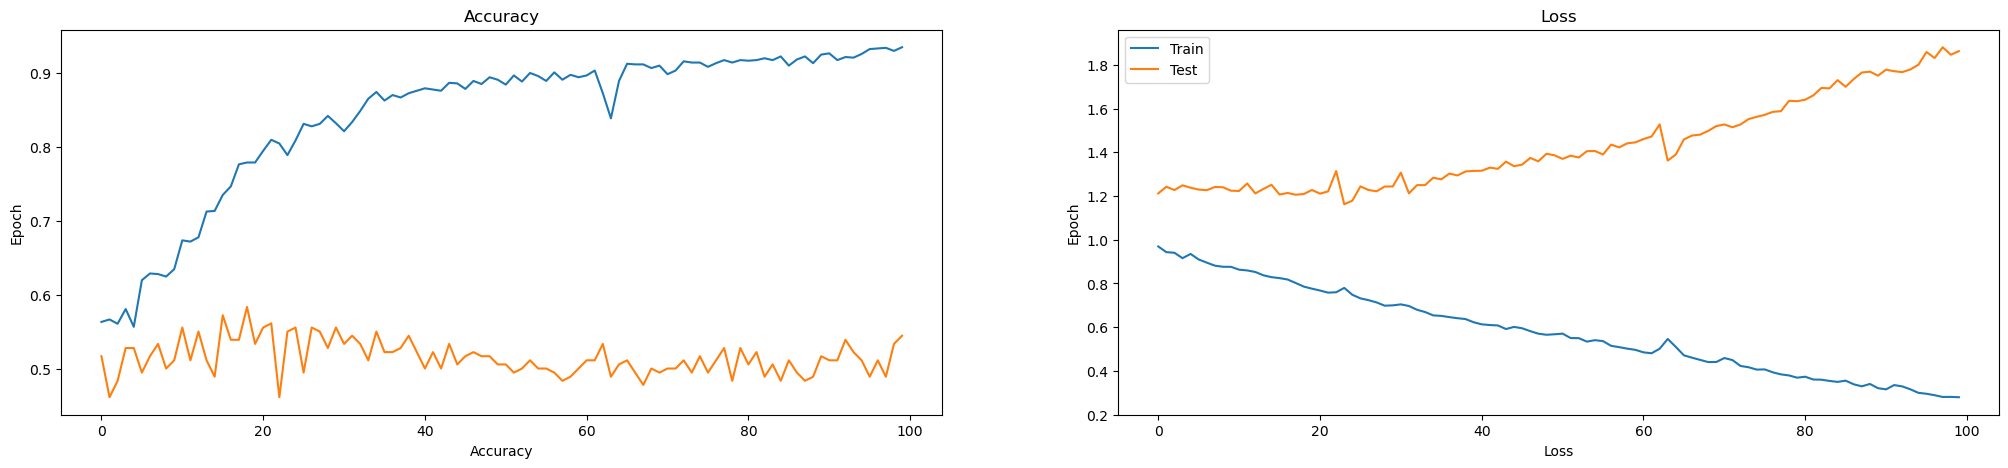

In [149]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(25, 5))
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Accuracy')
ax[0].set_xlabel('Accuracy')
ax[0].set_ylabel('Epoch')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Loss')
ax[1].set_xlabel('Loss')
ax[1].set_ylabel('Epoch')

plt.legend(['Train', 'Test'])
plt.show()

In [42]:
train_predictions = np.rint(model.predict(testing_padded, verbose=0)).argmax(axis=1).flatten()

train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':testing_label.argmax(axis=1)})
train_results['Diff'] = train_results['Actuals'] == train_results['Train Predictions']
print(train_results.head(5))
train_results['Diff'].value_counts()

   Train Predictions  Actuals  Diff
0                  0        0  True
1                  0        0  True
2                  0        0  True
3                  0        0  True
4                  0        0  True


True     690
False     94
Name: Diff, dtype: int64

In [43]:
y_pred = model.predict(testing_padded, verbose=0).argmax(axis=1)
print(classification_report(testing_label.argmax(axis=1),y_pred))

              precision    recall  f1-score   support

           0       0.85      0.92      0.88       392
           1       0.91      0.84      0.88       392

    accuracy                           0.88       784
   macro avg       0.88      0.88      0.88       784
weighted avg       0.88      0.88      0.88       784



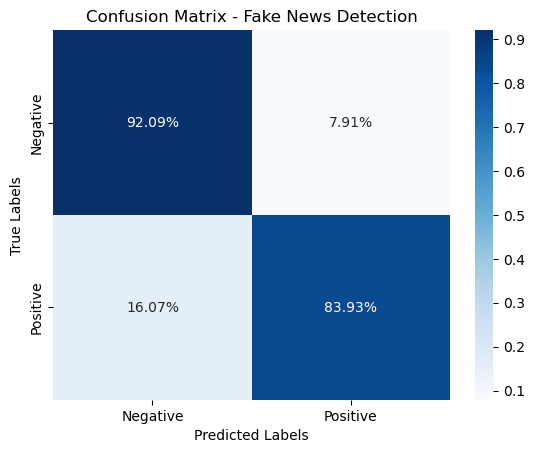

In [44]:
labels = y_train.columns

y_pred = np.rint(model.predict(testing_padded, verbose=0)).argmax(axis=1).flatten()
con_mat = confusion_matrix(testing_label.argmax(axis=1),y_pred)

cm_percent = con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_percent, annot=True, fmt='.2%', cmap='Blues', xticklabels=labels, yticklabels=labels)
# sns.heatmap(cm_percent, annot=True, fmt='.2%', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Fake News Detection')
plt.show()

# 6. Classification Algoritms

In [138]:
adaboost = AdaBoostClassifier(n_estimators=100, random_state=42)
bagging = BaggingClassifier(n_jobs=-1)
extraTrees = ExtraTreesClassifier(max_depth=100, n_jobs=-1, random_state=42)
gradient = GradientBoostingClassifier(max_depth=100, n_estimators=100, learning_rate=.01,  random_state=42)
randomForest = RandomForestClassifier(max_depth=100, random_state=42, n_jobs=-1)
histGradientBoosting = HistGradientBoostingClassifier()
XGB = XGBClassifier(n_jobs=-1)
knn = KNeighborsClassifier(n_jobs=-1)
decisionTree = DecisionTreeClassifier(random_state=42, max_depth=100)
linear = LinearRegression()
pac = PassiveAggressiveClassifier(random_state=42)

model = StackingClassifier([
    ('XGB', XGB),
    ('randomforest', randomForest),
    ('histGradientBoosting', histGradientBoosting),
    ('adaboost', adaboost),
    ('bagging', bagging),
    ('extraTres', extraTrees),
    ('knn', knn),
    ('decisionTree', decisionTree),
    # ('pac', pac),
    # ('linear', linear),
    # ('gradient', gradient),

], n_jobs=-1)

In [139]:
model.fit(training_padded, training_label)

c:\Users\indiz\miniconda3\envs\gan\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


StackingClassifier(estimators=[('XGB',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None, gamma=None,
                                              gpu_id=None, grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                              learning_...
                               ('histGradientB

In [140]:
print("Train Score        :",round((model.score(training_padded, training_label)*100), 2),'%')
print("Test Score         :",round((model.score(testing_padded, testing_label)*100), 2),'%')

y_pred = model.predict(testing_padded)

print("R Squared Error    :",round(r2_score(testing_label, y_pred), 2))
print("Mean Squared Error :",round(mean_squared_error(testing_label, y_pred), 2))
print("Mean Absolute Error:",round(mean_absolute_error(testing_label, y_pred), 2))

Train Score        : 100.0 %
Test Score         : 41.94 %
R Squared Error    : -0.62
Mean Squared Error : 2.02
Mean Absolute Error: 1.0


In [141]:
train_predictions = model.predict(testing_padded).flatten()

train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':testing_label})
train_results['Diff'] = train_results['Actuals'] == train_results['Train Predictions']
print(train_results.head(5))
train_results['Diff'].value_counts()

   Train Predictions  Actuals   Diff
0                  0        0   True
1                  0        0   True
2                  0        0   True
3                  2        0  False
4                  3        0  False


False    216
True     156
Name: Diff, dtype: int64

In [117]:
y_pred = model.predict(testing_padded)
print(classification_report(y_pred,testing_label))

              precision    recall  f1-score   support

           0       0.26      0.31      0.28        36
           1       0.05      0.05      0.05        41
           2       0.02      0.05      0.03        22
           3       0.14      0.09      0.11        67
           4       0.09      0.12      0.11        32
           5       0.23      0.20      0.22        49
           6       0.09      0.07      0.08        56
           7       0.12      0.08      0.10        62
           8       0.05      0.05      0.05        40
           9       0.12      0.14      0.13        35
          10       0.00      0.00      0.00        31
          11       0.00      0.00      0.00        12
          12       0.07      0.07      0.07        45
          13       0.07      0.06      0.06        54
          14       0.07      0.08      0.07        37
          15       0.02      0.05      0.03        21
          16       0.09      0.15      0.11        27
          17       0.05    

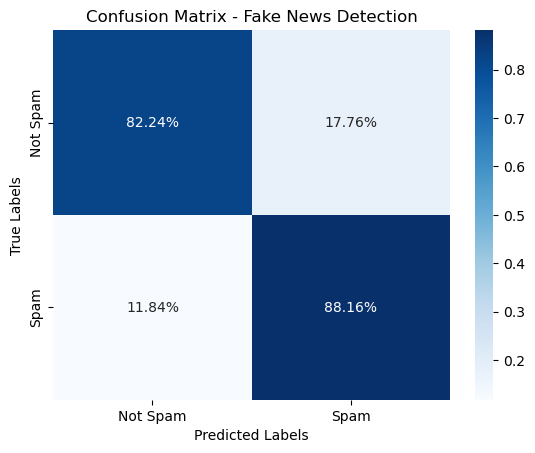

In [68]:
labels = ['Not Spam','Spam']

y_pred = np.rint(model.predict(testing_padded))
con_mat = confusion_matrix(testing_label,y_pred)

cm_percent = con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_percent, annot=True, fmt='.2%', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Fake News Detection')
plt.show()